In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import json
import os
from collections import defaultdict
import sys
sys.path.append('../')
from temperature_scaling import rescale_prob

#### Temperature Scaling for Biased Coinflip

In [3]:
# Specify the file name
coinflip_p_path='{}/../results/biased_coin/gpt-4/model_logprobs/'.format(os.getcwd())
file_name = coinflip_p_path+"expected_coinflip_p.json"
# Read data from a JSON file
with open(file_name, 'r') as json_file:
    expected_data = json.load(json_file)

file_name = coinflip_p_path+"actual_coinflip_p.json"

# Read data from a JSON file
with open(file_name, 'r') as json_file:
    actual_data = json.load(json_file)

model_ps, reference_ps = [], []
for i, d in enumerate(actual_data): 
    model_ps.append(d)
    reference_ps.append(expected_data[i])

rescaled_ps, _ = rescale_prob(model_ps, reference_ps)

rescale_p_h = np.array(rescaled_ps)[:, 0]
reference_p_h  = np.array(reference_ps)[:, 0]


8.105402620578722


In [4]:
# Setting font sizes
plt.rcParams.update({
    'font.size': 14,          # Default text size
    'axes.titlesize': 16,     # Axes title size
    'axes.labelsize': 16,     # Axes label size
    'xtick.labelsize': 14,    # X-tick label size
    'ytick.labelsize': 14,    # Y-tick label size
    'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 18    # Figure title size
})

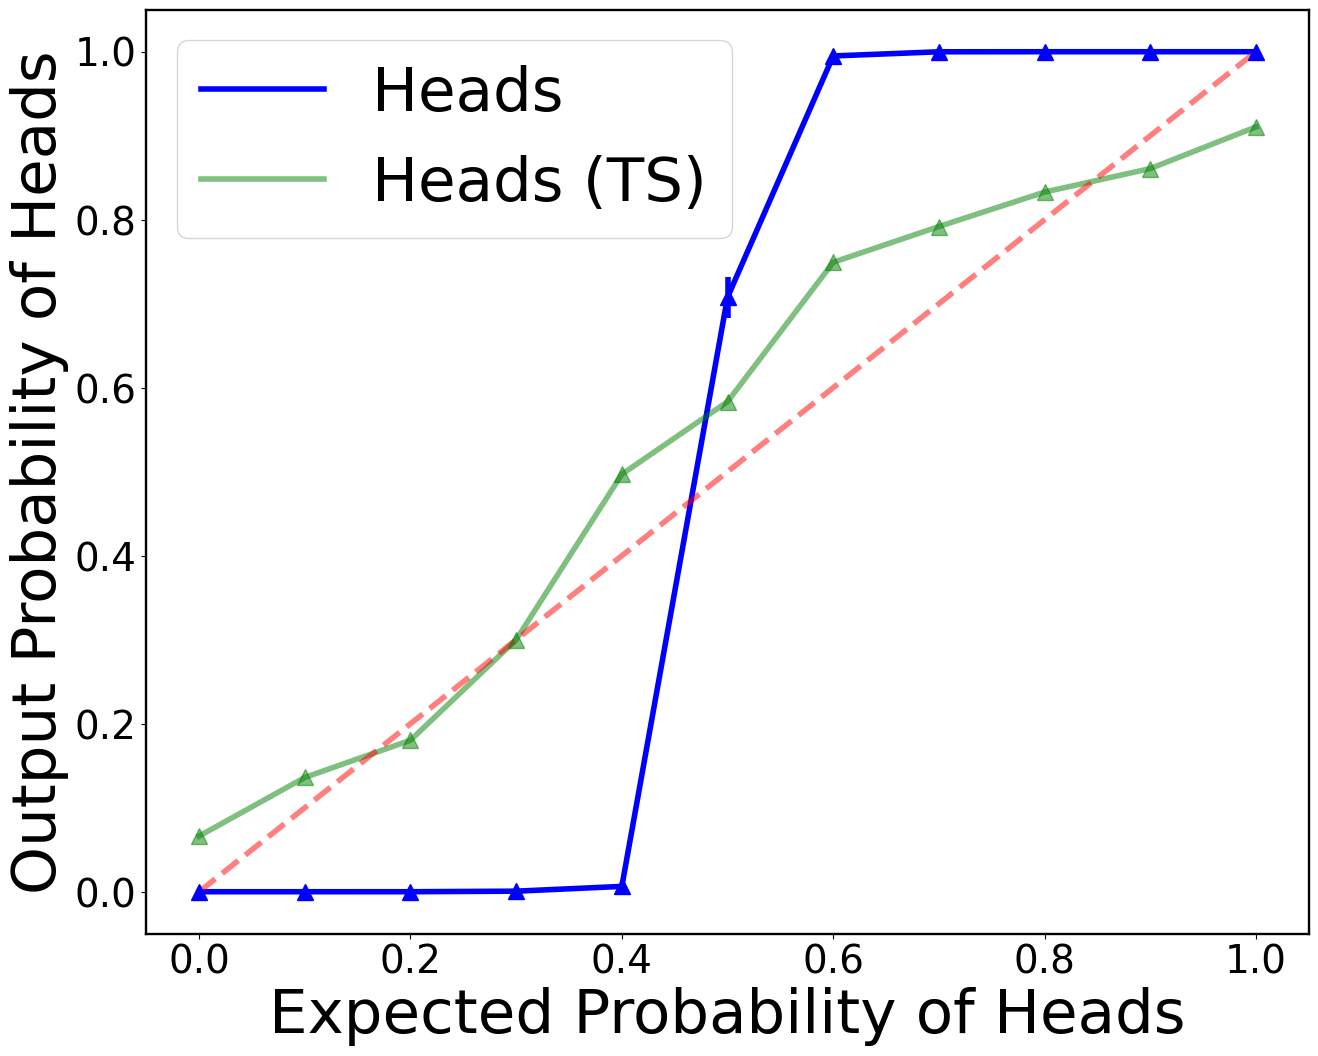

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict

# Setting font sizes and scaling other parameters
scale_factor = 2
plt.rcParams.update({
    'font.size': 18 * scale_factor,          # Default text size
    'axes.titlesize': 16 * scale_factor,     # Axes title size
    'axes.labelsize': 22 * scale_factor,     # Axes label size
    'xtick.labelsize': 14 * scale_factor,    # X-tick label size
    'ytick.labelsize': 14 * scale_factor,    # Y-tick label size
    'legend.fontsize': 22 * scale_factor,    # Legend font size
    'figure.titlesize': 18 * scale_factor    # Figure title size
})

key_to_color= {'h': 'b', 't': 'g'}
key_to_name = {'h': 'Heads', 't': 'Tails'}

path = '/Users/nicolemeister/Desktop/STANFORD/distributions/results/biased_coin/'

model='gpt-4'  # load data

with open(path + model + '/biased_coin_benchmark.json', 'r') as file:
  # Load JSON data into a dictionary
  data = json.load(file)

expected, actual_all, expected_all, actual_mean, actual_std = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

for i, question in enumerate(list(data.keys())):
  if i % 2 == 1:
    expected_results = data[question]['expected_results']
    actual_results = data[question]['actual_results']
    
    avg_expected_results = data[question]['avg_expected_results']
    std_expected_results = data[question]['std_expected_results']

    # if actual results has any [], fill it with zeros 
    for key in list(actual_results.keys()):
      if not actual_results[key]:
          actual_results[key] = list(np.zeros(5))
          avg_expected_results[key] = 0
          std_expected_results[key] = 0
    # Expand expected results to the size of actual results 
    for key in list(expected_results.keys()):
      expected_results[key] = list(expected_results[key] * np.ones(len(actual_results[key])))
    
    for key in list(expected_results.keys()):
      expected_all[key] += expected_results[key]
      actual_all[key] += actual_results[key]

      expected[key].append(expected_results[key][0])
      actual_mean[key].append(avg_expected_results[key])
      actual_std[key].append(std_expected_results[key])

plt.figure(figsize=(15, 12))  # Double the size of the figure

for key in list(expected_results.keys())[0]:
    plt.plot(expected[key], actual_mean[key], label=key_to_name[key], color=key_to_color[key], markersize=6 * scale_factor, linewidth=2 * scale_factor)
    plt.errorbar(expected[key], actual_mean[key], actual_std[key], linestyle='None', color=key_to_color[key], marker='^', markersize=6 * scale_factor, linewidth=2 * scale_factor)
    plt.xlabel("Expected Probability of Heads")
    plt.ylabel("Output Probability of Heads")

# Assuming rescale_p_h is defined somewhere in your code
plt.plot(expected[key], rescale_p_h[::-1], label="Heads (TS)", color='green', alpha=0.5, markersize=6 * scale_factor, linewidth=2 * scale_factor)
plt.errorbar(expected[key], rescale_p_h[::-1], np.zeros(len(rescale_p_h)), linestyle='None', color='green', marker='^', alpha=0.5, markersize=6 * scale_factor, linewidth=2 * scale_factor)

plt.legend()
x = np.linspace(0, 1, 100)
plt.plot(x, x, 'r--', label='y=x', alpha=0.5, linewidth=2 * scale_factor)

# Change the plot bounding box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.85*scale_factor)



plt.savefig('/Users/nicolemeister/Desktop/STANFORD/distributions/figures/biased_coinflip/model_logprob.svg')

plt.show()


### Calibration Curves for Survey Datasets (OQA, NYT, GlobalValues)

In [6]:
import pandas as pd

dataset_to_demgroup = {'opinionqa': ['POLPARTY', 'SEX', 'RACE'], 'nytimes': ['POLPARTY', 'SEX'], 'globalvalues': ['globalvalues'] }
dem_group_to_dem_mapping = {'POLPARTY': ['Democrat', 'Republican'],
                            'SEX': ['Male', 'Female'],
                            'RACE': ['Black', 'White'], 
                            'globalvalues': ['0', '1', '2']}


def bin_data(expected_probabilities, output_probabilities, n_bins = 20):

    # Create bins for expected probabilities (uniformly spaced between 0 and 1)
    bins = np.linspace(np.nanmin(output_probabilities), np.nanmax(output_probabilities), n_bins + 1)
    # Bin the data
    bin_indices = np.digitize(output_probabilities, bins)  # Find which bin each x-value belongs to
    # Create a DataFrame for easier manipulation and calculate means for each bin
    bin_means = pd.DataFrame({
        'expected': expected_probabilities,
        'output': output_probabilities,
        'bin': bin_indices
    }).groupby('bin').mean()
    
    bin_std = pd.DataFrame({
        'expected': expected_probabilities,
        'output': output_probabilities,
        'bin': bin_indices
    }).groupby('bin').std()

    # Display the binned data
    return bin_means['expected'], bin_means['output'], bin_std['expected'], bin_std['output']


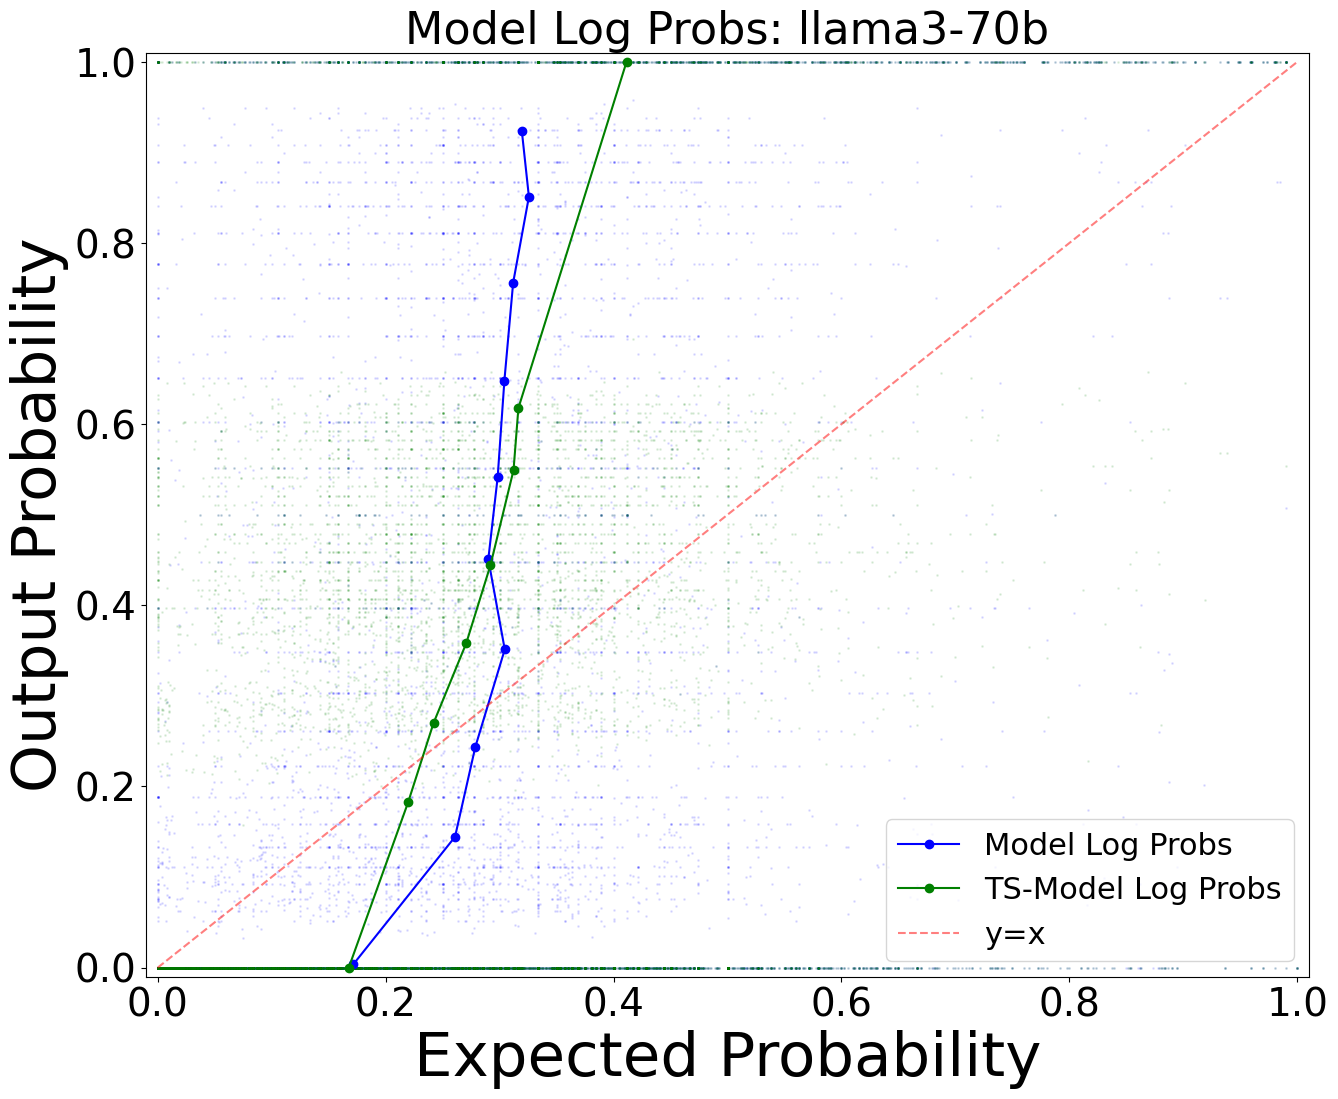

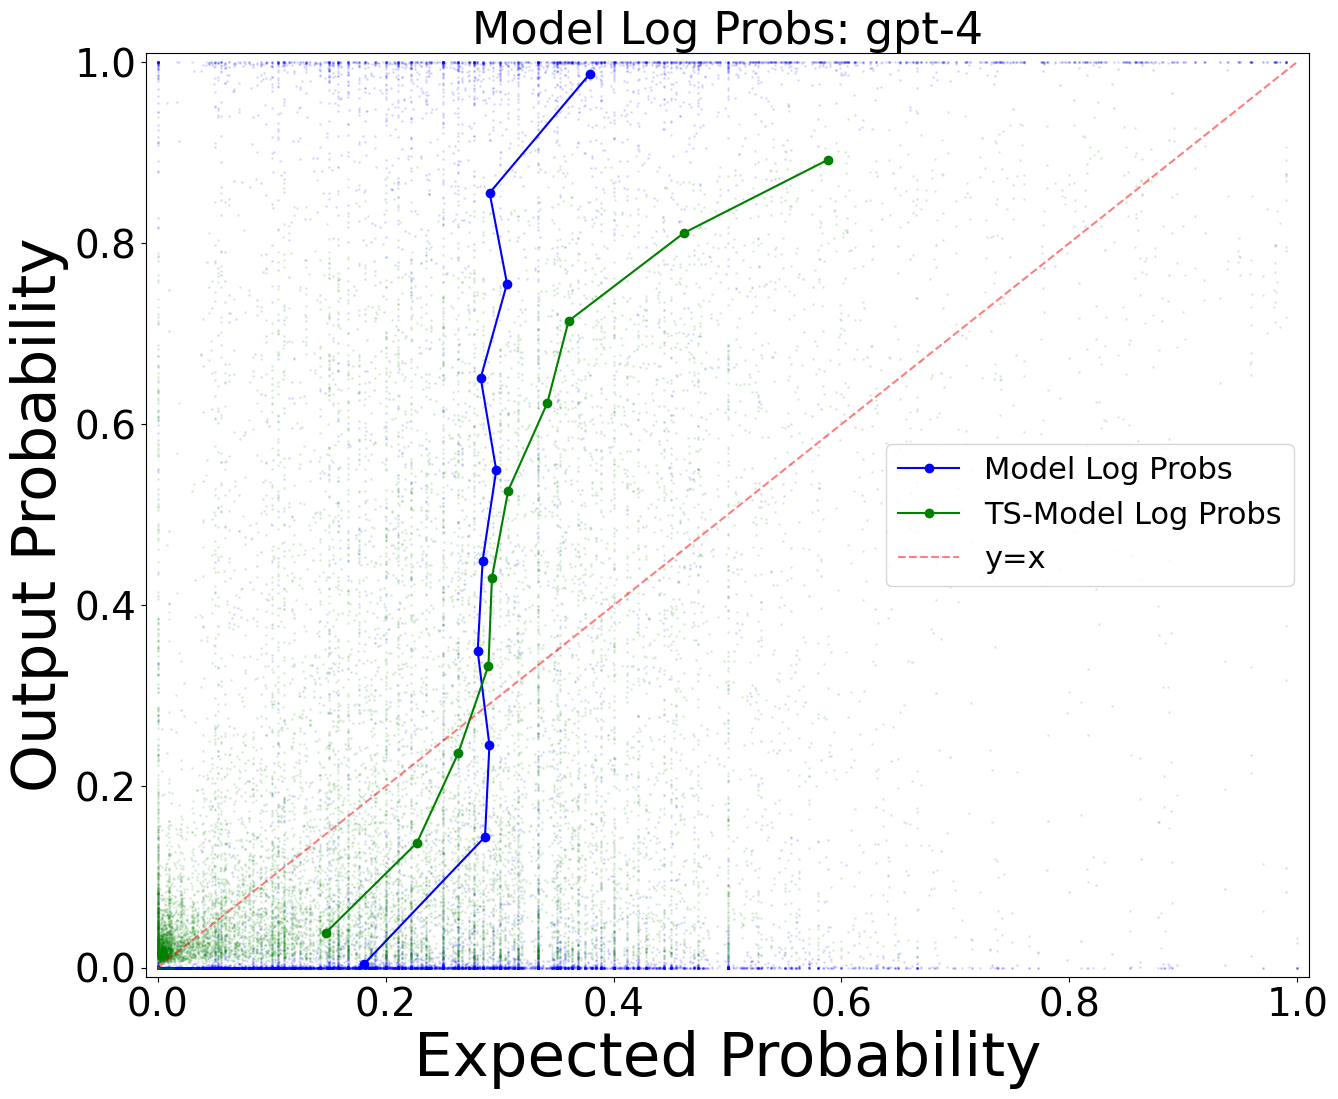

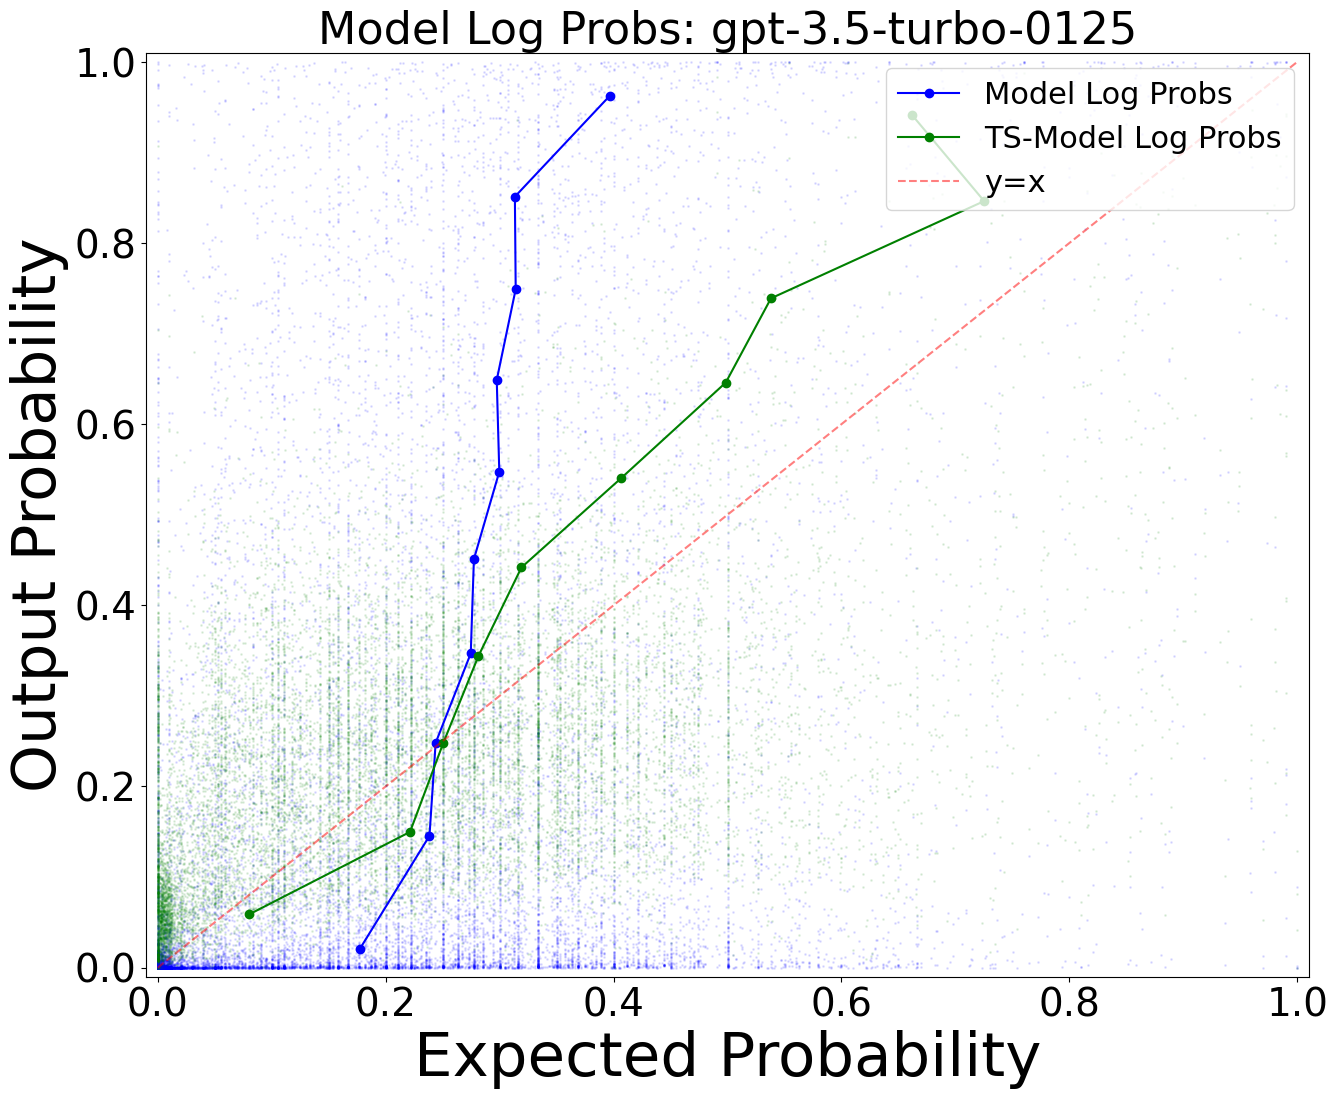

In [15]:
# one plot per model and per dataset 
# x axis: expected probability
# y axis: output probability 

for model in ['llama3-70b', 'gpt-4', 'gpt-3.5-turbo-0125']:
    expected_probabilities_lst_ts, output_probabilities_lst_ts = [], []
    expected_probabilities_lst_no_ts, output_probabilities_lst_no_ts = [], []
    expected_probabilities_lst_verbalize, output_probabilities_lst_verbalize = [], []
    for dataset in ['opinionqa', 'nytimes', 'globalvalues']:
        # expected_probabilities_lst_ts, output_probabilities_lst_ts = [], []
        # expected_probabilities_lst_no_ts, output_probabilities_lst_no_ts = [], []
        # expected_probabilities_lst_verbalize, output_probabilities_lst_verbalize = [], []
        # # for model in ['gpt-4']: 
        for steering_method in ['task1', 'task3_easy_hard']:
            for dem_group in dataset_to_demgroup[dataset]:
                for dem in dem_group_to_dem_mapping[dem_group]:
                    
                    if dataset=='opinionqa': wave='Pew_American_Trends_Panel_disagreement_100'
                    else: wave=''
                
                    file_name = '{}/../results/{}/rescaled_model_logprobs/{}/{}/{}/{}/{}.json'.format(os.getcwd(), dataset,model,steering_method, wave, dem_group, dem)
                    
                    # Read data from a JSON file
                    with open(file_name, 'r') as json_file:
                        dem_data = json.load(json_file)
                    
                    for i, qID in enumerate(dem_data):
                        expected_probabilities_lst_ts.append(dem_data[qID]['expected_results'].values())
                        output_probabilities_lst_ts.append(dem_data[qID]['avg_actual_results'].values())


                    file_name = '{}/../results/{}/model_logprobs/{}/{}/{}/{}/{}.json'.format(os.getcwd(), dataset,model,steering_method, wave, dem_group, dem)
                    
                    # Read data from a JSON file
                    with open(file_name, 'r') as json_file:
                        dem_data = json.load(json_file)
                    
                    for i, qID in enumerate(dem_data):
                        expected_probabilities_lst_no_ts.append(dem_data[qID]['expected_results'].values())
                        output_probabilities_lst_no_ts.append(dem_data[qID]['avg_actual_results'].values())

                
    expected_probabilities_ts = [item for sublist in expected_probabilities_lst_ts for item in sublist]
    expected_probabilities_no_ts = [item for sublist in expected_probabilities_lst_no_ts for item in sublist]
    
    output_probabilities_ts = [item for sublist in output_probabilities_lst_ts for item in sublist]
    output_probabilities_no_ts = [item for sublist in output_probabilities_lst_no_ts for item in sublist]    
    

    expected_mean_ts, output_mean_ts, expected_std_ts, output_std_ts = bin_data(expected_probabilities_ts, output_probabilities_ts, n_bins =10)
    expected_mean_no_ts, output_mean_no_ts, expected_std_no_ts, output_std_no_ts = bin_data(expected_probabilities_no_ts, output_probabilities_no_ts, n_bins =10)

    # Create the calibration curve plot
    plt.figure(figsize=(15, 12))

    plt.plot(expected_mean_no_ts[:10], output_mean_no_ts[:10], marker='o', linestyle='-', color='b',  label='Model Log Probs')
    plt.plot(expected_mean_ts[:10], output_mean_ts[:10], marker='o', linestyle='-', color='g', label='TS-Model Log Probs')

    # plt.errorbar(expected_mean_no_ts.tolist(), output_mean_no_ts.tolist(), yerr=output_std_no_ts, 
    #         marker='o', linestyle='-', color='b', label='Model Log Probs', alpha=0.7)


    # plt.errorbar(expected_mean_ts.tolist()[:10], output_mean_ts.tolist()[:10], yerr=output_std_ts[:10], 
    #         marker='o', linestyle='-', color='g', label='TS-Model Log Probs', alpha=0.7)

    plt.scatter(expected_probabilities_no_ts, output_probabilities_no_ts, s=1, color='b', alpha=0.1)
    plt.scatter(expected_probabilities_ts, output_probabilities_ts, s=1,color='g', alpha=0.1)

    plt.xlabel('Expected Probability')
    plt.ylabel('Output Probability')
    plt.title('Model Log Probs: {}'.format(model))
    x = np.linspace(0, 1, 100)
    # Plot y=x as a red dashed line
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot(x, x, 'r--', label='y=x', alpha=0.5)
    plt.legend()
    plt.show()

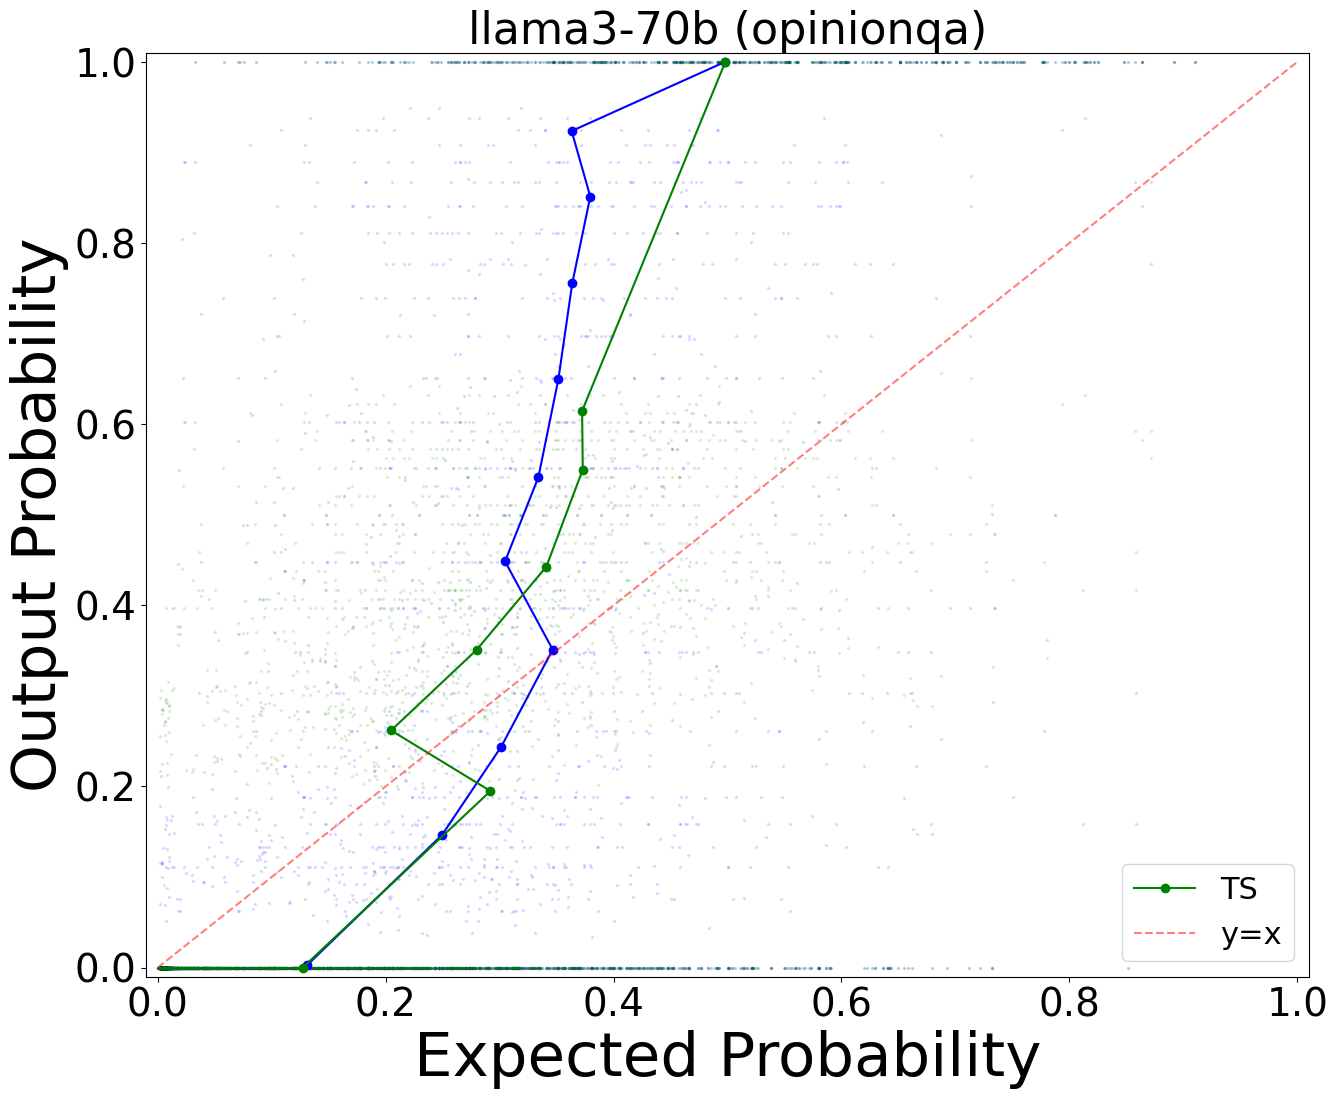

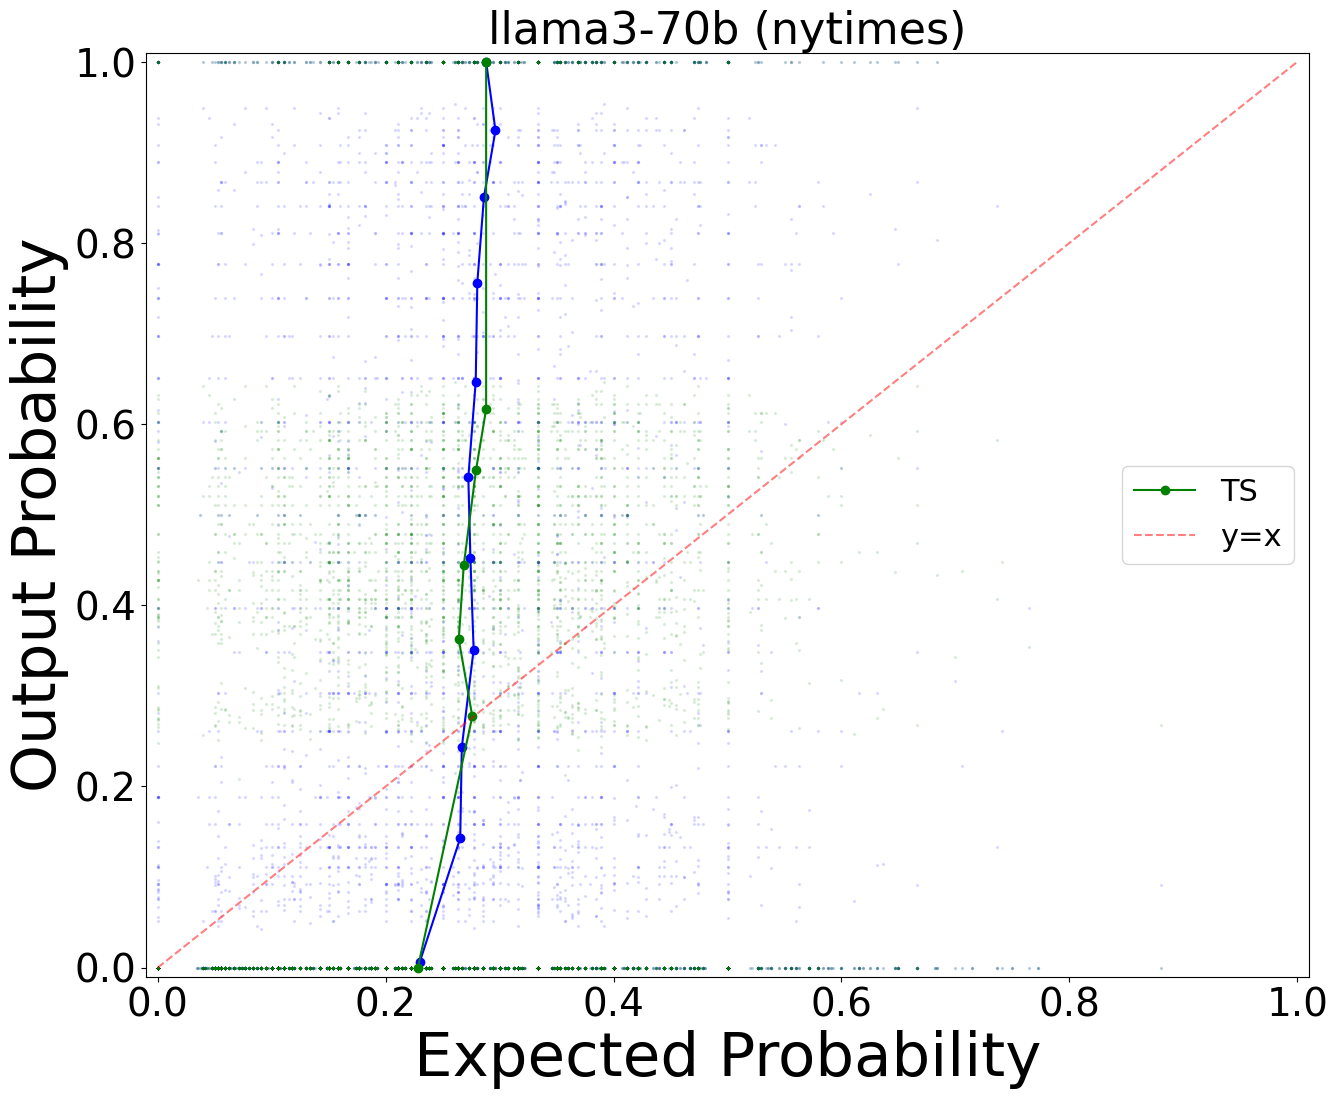

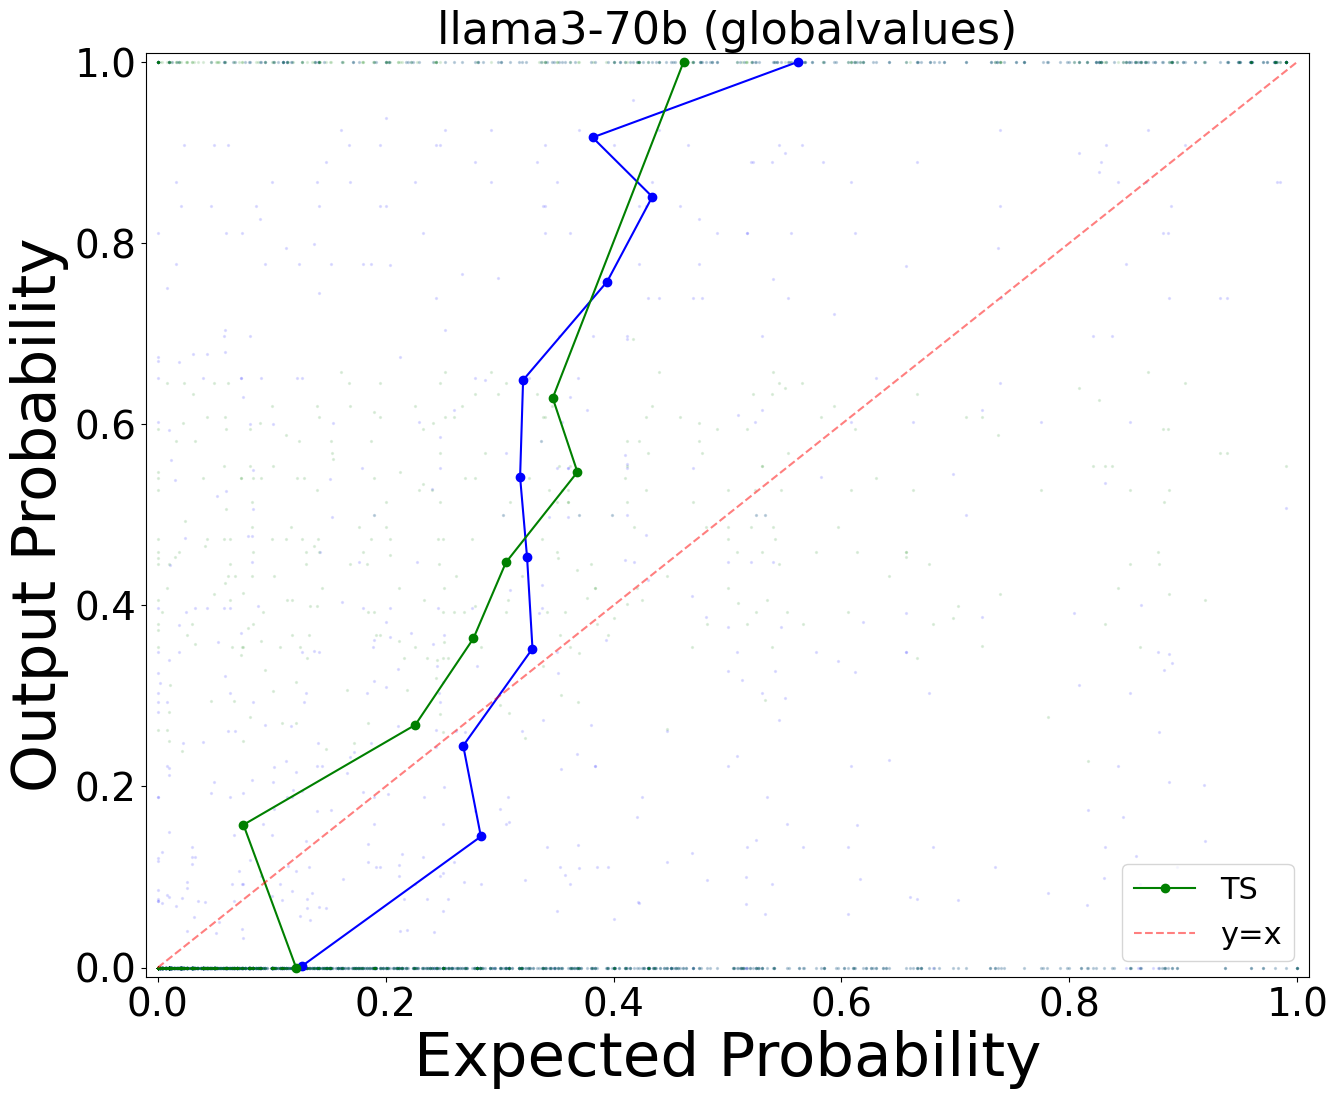

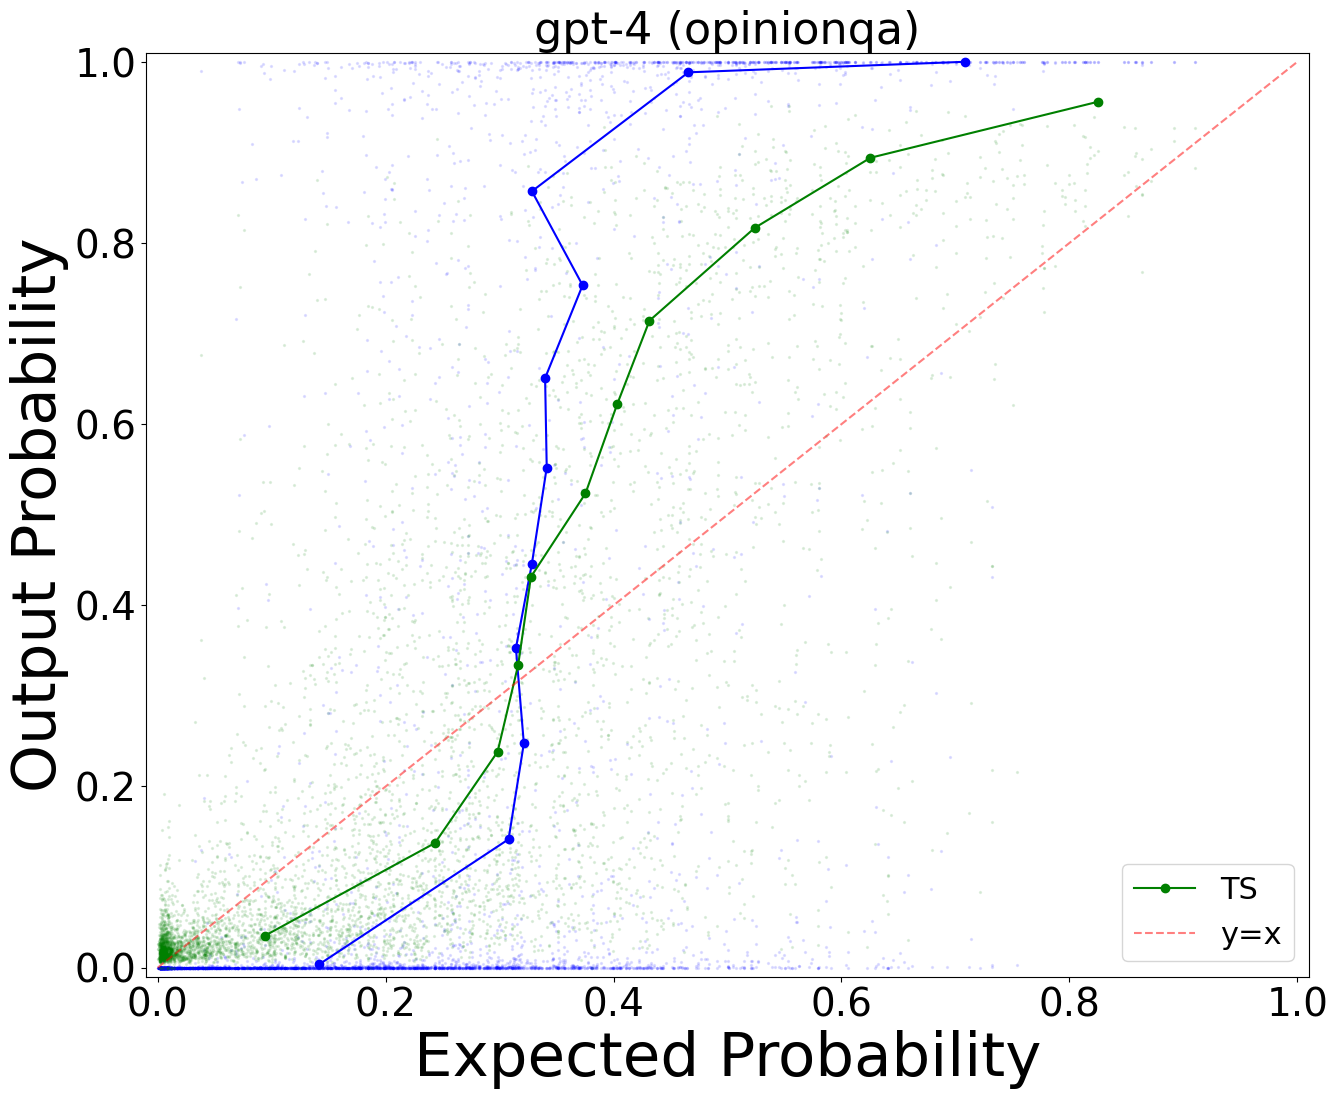

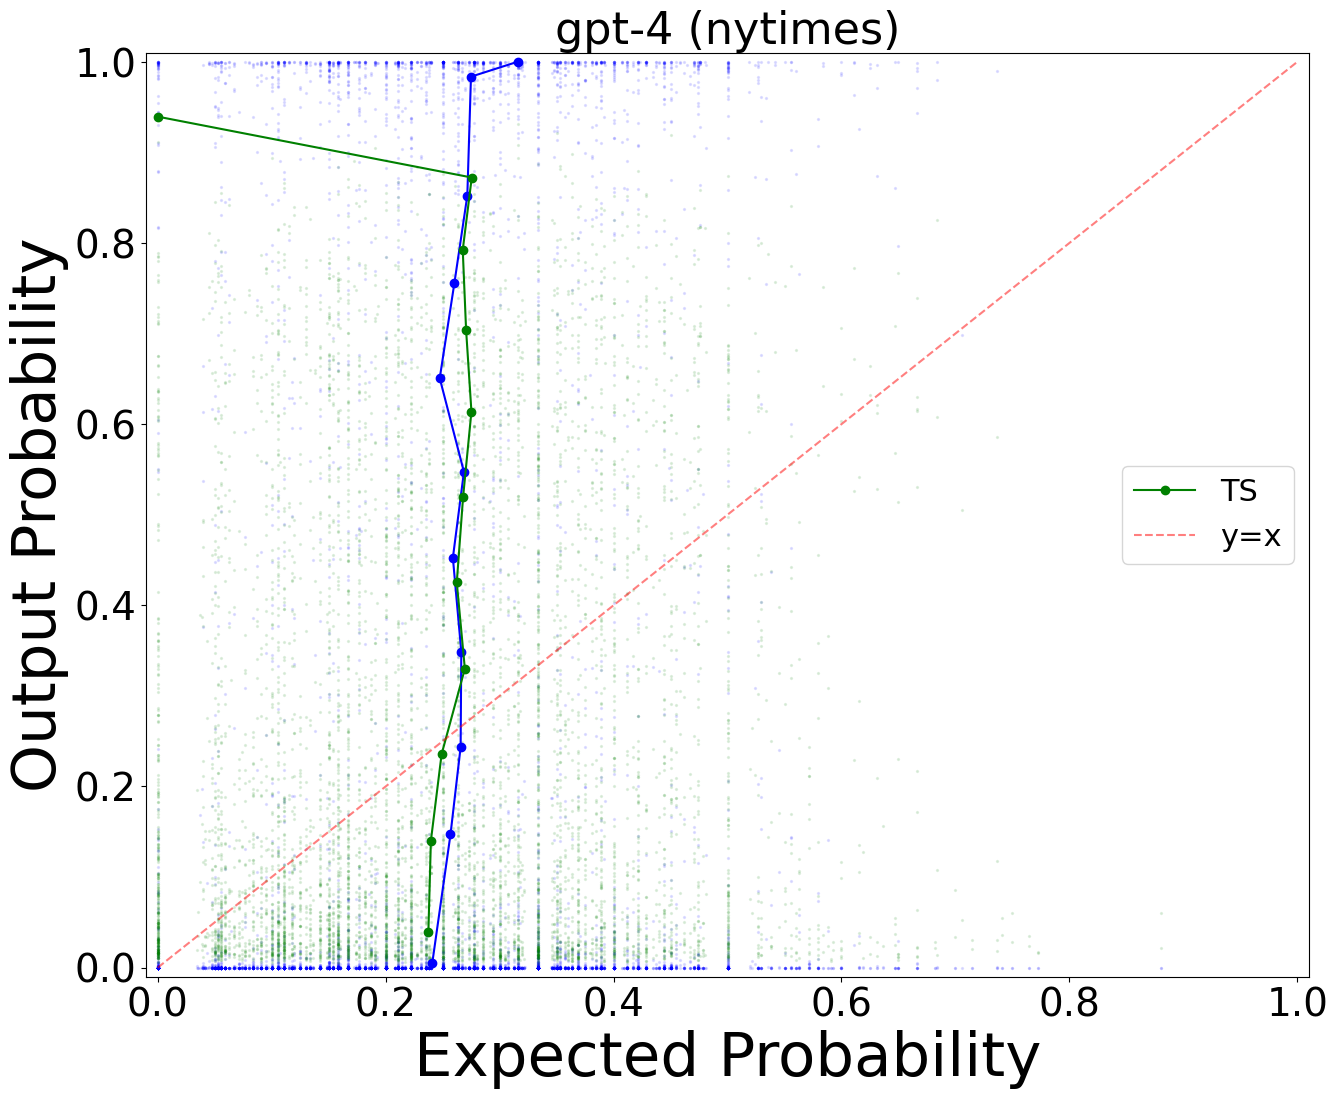

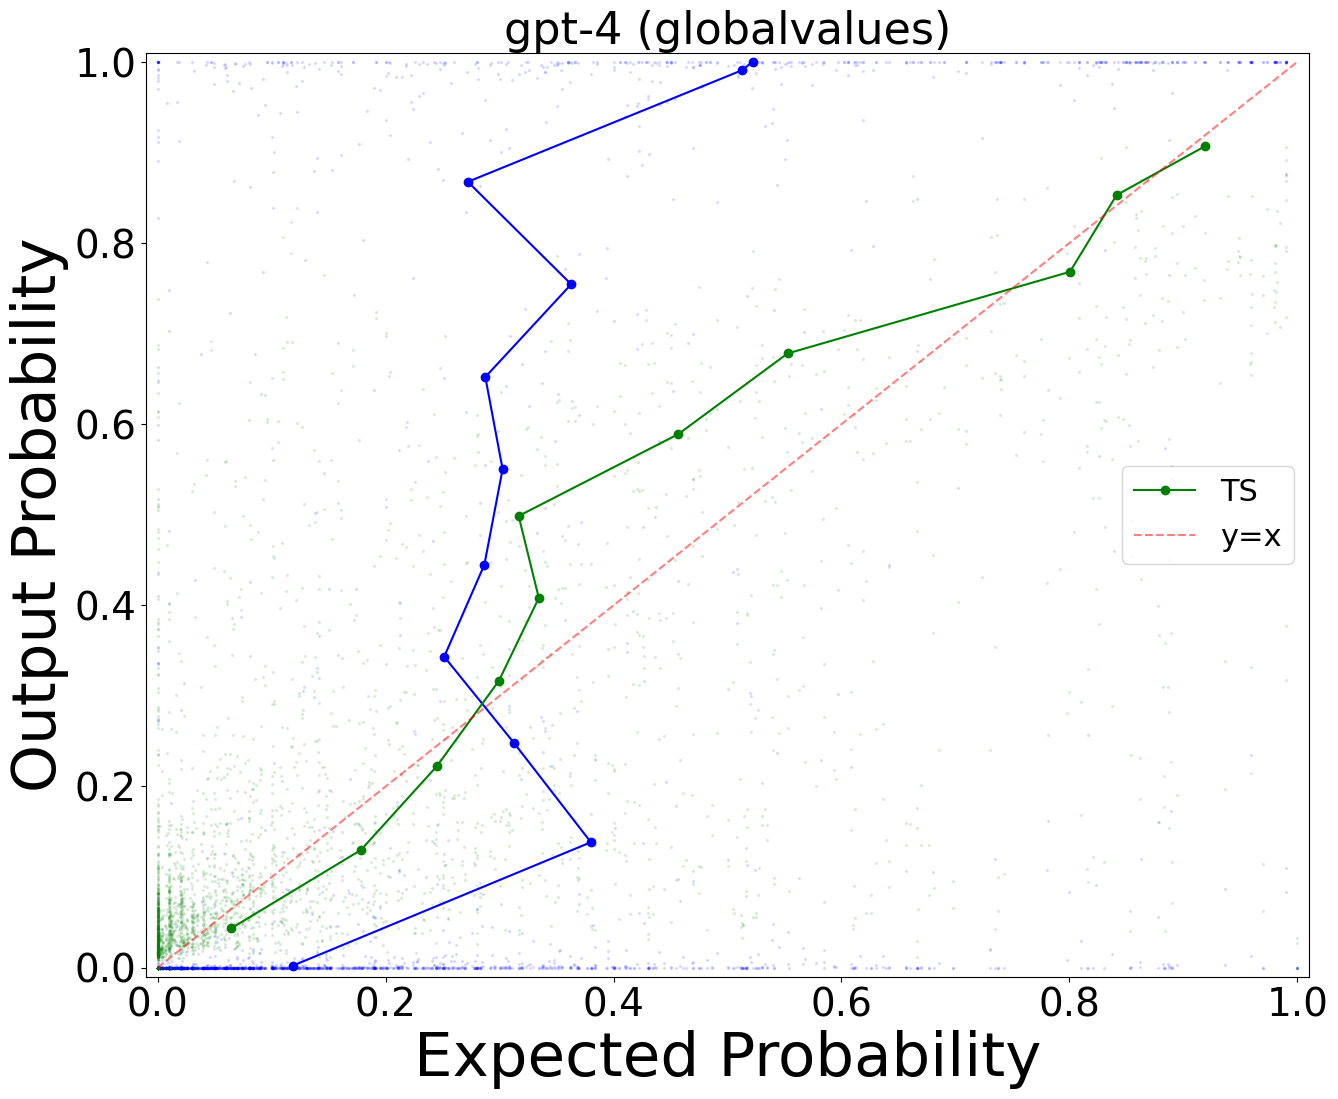

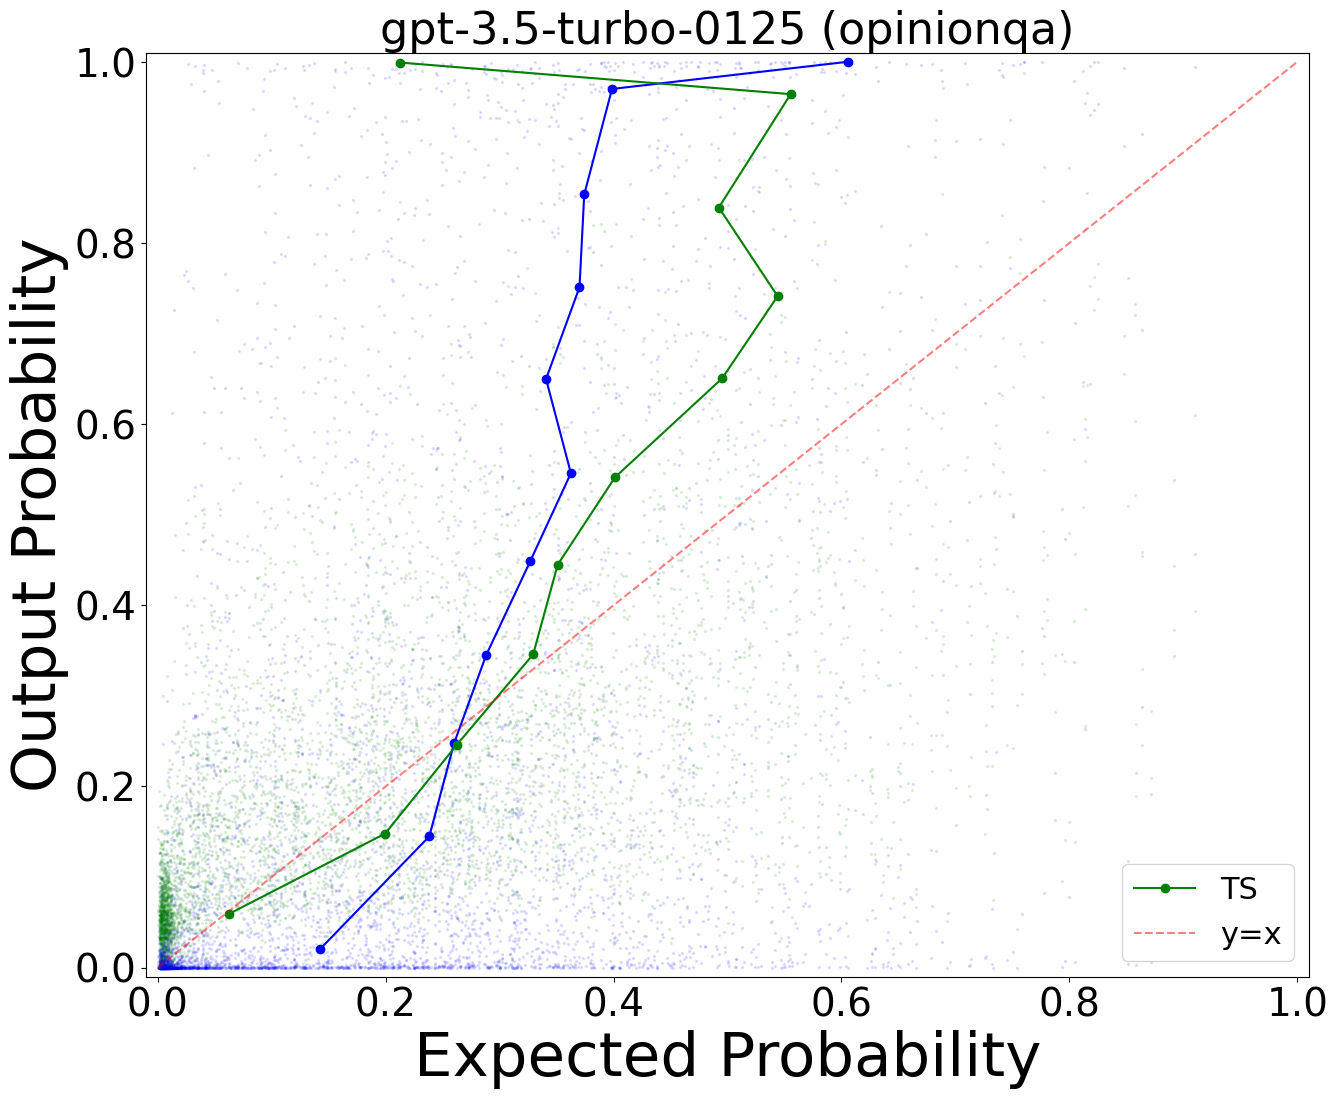

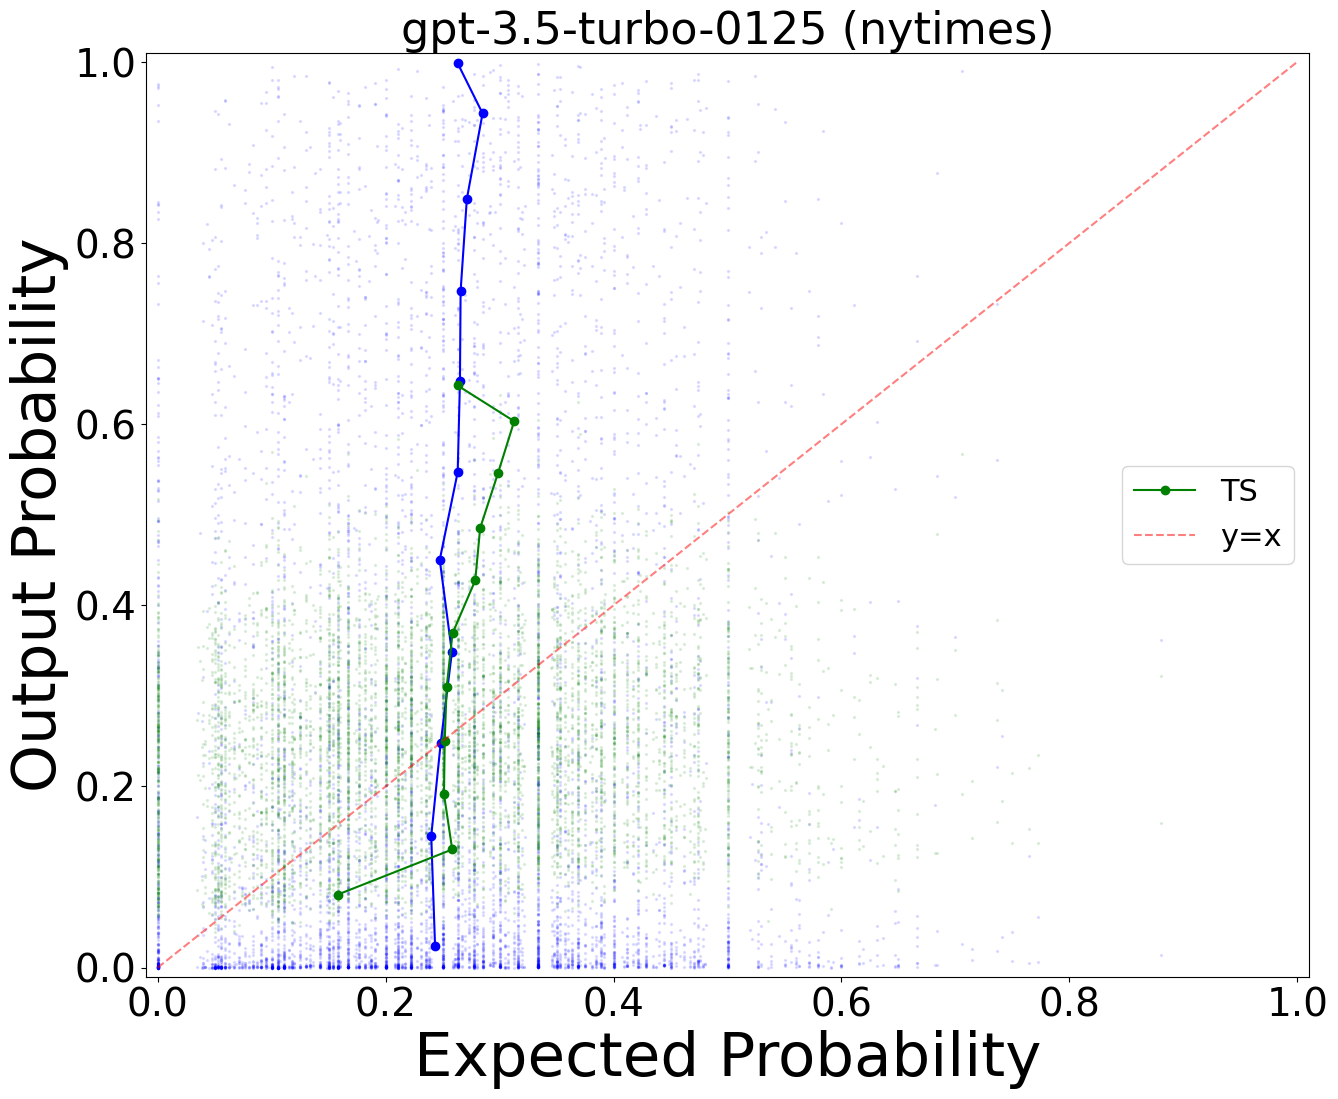

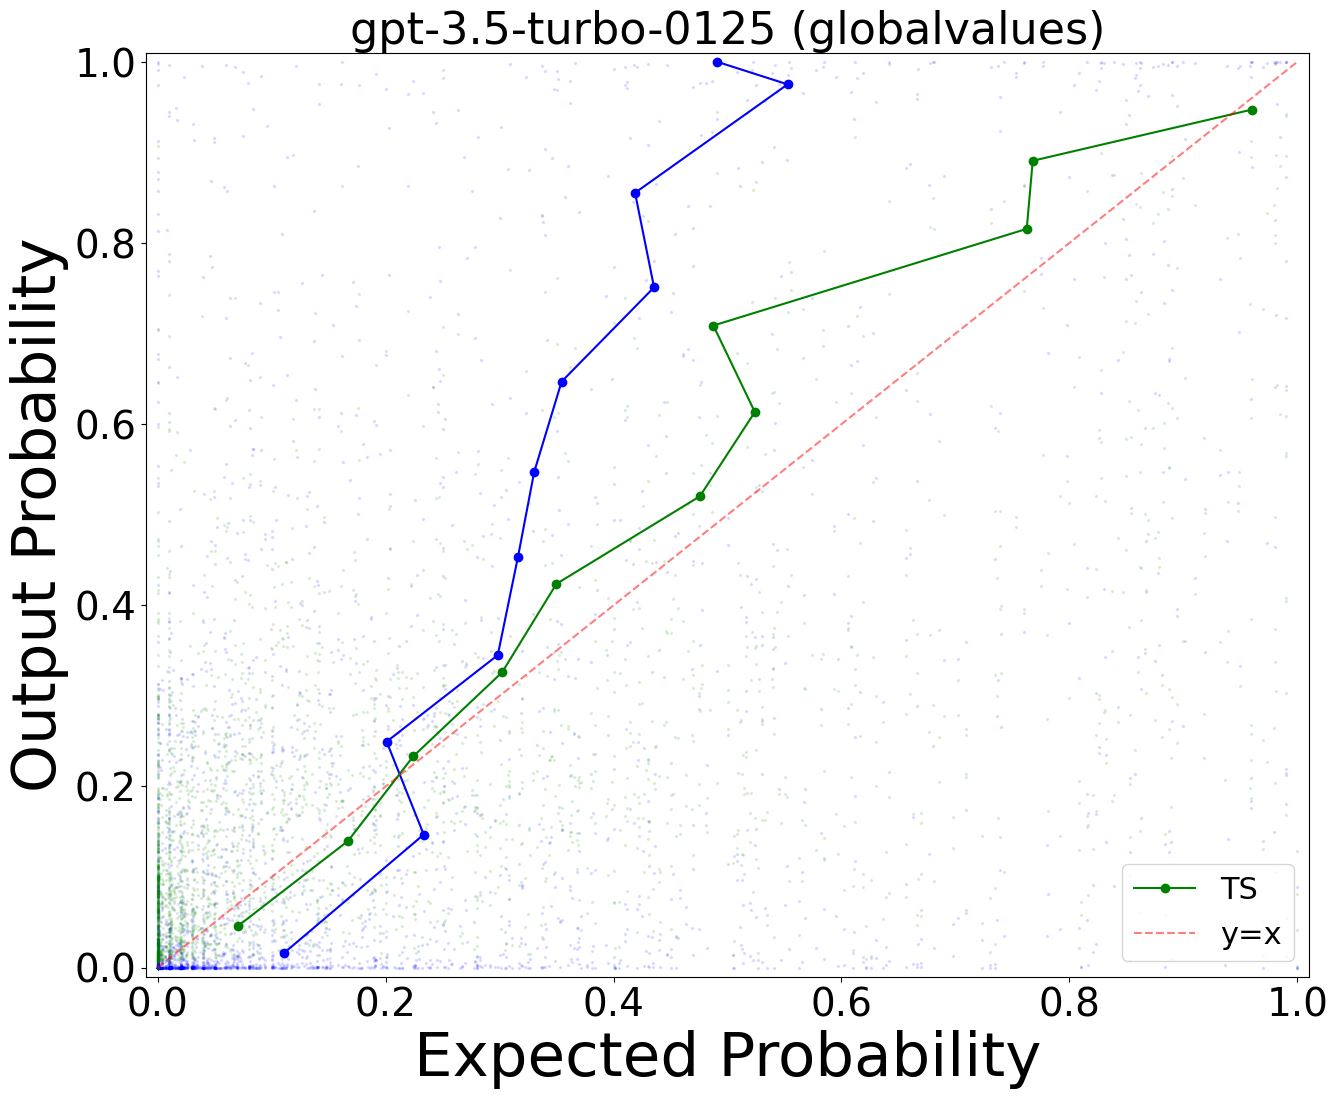

In [9]:
# one plot per model and per dataset 
# x axis: expected probability
# y axis: output probability 

# Setting font sizes and scaling other parameters
scale_factor = 2
plt.rcParams.update({
    'font.size': 18 * scale_factor,          # Default text size
    'axes.titlesize': 16 * scale_factor,     # Axes title size
    'axes.labelsize': 22 * scale_factor,     # Axes label size
    'xtick.labelsize': 14 * scale_factor,    # X-tick label size
    'ytick.labelsize': 14 * scale_factor,    # Y-tick label size
    'legend.fontsize': 22 ,    # Legend font size
    'figure.titlesize': 18 * scale_factor    # Figure title size
})

for model in ['llama3-70b', 'gpt-4', 'gpt-3.5-turbo-0125']:
    for dataset in ['opinionqa', 'nytimes', 'globalvalues']:
        expected_probabilities_lst_ts, output_probabilities_lst_ts = [], []
        expected_probabilities_lst_no_ts, output_probabilities_lst_no_ts = [], []
        expected_probabilities_lst_verbalize, output_probabilities_lst_verbalize = [], []
        # for model in ['gpt-4']: 
        for steering_method in ['task1', 'task3_easy_hard']:
            for dem_group in dataset_to_demgroup[dataset]:
                for dem in dem_group_to_dem_mapping[dem_group]:
                    
                    if dataset=='opinionqa': wave='Pew_American_Trends_Panel_disagreement_100'
                    else: wave=''
                
                    file_name = '{}/../results/{}/rescaled_model_logprobs/{}/{}/{}/{}/{}.json'.format(os.getcwd(),dataset,model,steering_method, wave, dem_group, dem)
                    
                    # # Read data from a JSON file
                    with open(file_name, 'r') as json_file:
                        dem_data = json.load(json_file)
                    
                    for i, qID in enumerate(dem_data):
                        expected_probabilities_lst_ts.append(dem_data[qID]['expected_results'].values())
                        output_probabilities_lst_ts.append(dem_data[qID]['avg_actual_results'].values())


                    file_name = '{}/../results/{}/model_logprobs/{}/{}/{}/{}/{}.json'.format(os.getcwd(),dataset,model,steering_method, wave, dem_group, dem)
                    
                    # Read data from a JSON file
                    with open(file_name, 'r') as json_file:
                        dem_data = json.load(json_file)
                    
                    for i, qID in enumerate(dem_data):
                        expected_probabilities_lst_no_ts.append(dem_data[qID]['expected_results'].values())
                        output_probabilities_lst_no_ts.append(dem_data[qID]['avg_actual_results'].values())


        expected_probabilities_ts = [item for sublist in expected_probabilities_lst_ts for item in sublist]
        expected_probabilities_no_ts = [item for sublist in expected_probabilities_lst_no_ts for item in sublist]
        
        output_probabilities_ts = [item for sublist in output_probabilities_lst_ts for item in sublist]
        output_probabilities_no_ts = [item for sublist in output_probabilities_lst_no_ts for item in sublist]
        

        expected_mean_ts, output_mean_ts, expected_std_ts, output_std_ts = bin_data(expected_probabilities_ts, output_probabilities_ts, n_bins =10)
        expected_mean_no_ts, output_mean_no_ts, expected_std_no_ts, output_std_no_ts = bin_data(expected_probabilities_no_ts, output_probabilities_no_ts, n_bins =10)

        # Create the calibration curve plot
        plt.figure(figsize=(15, 12))
        plt.plot(expected_mean_no_ts, output_mean_no_ts, marker='o', linestyle='-', color='b')
        plt.plot(expected_mean_ts, output_mean_ts, marker='o', linestyle='-', color='g', label='TS')

        # plt.errorbar(expected_mean_no_ts.tolist(), output_mean_no_ts.tolist(), 
        # yerr=output_std_no_ts, 
        #         marker='o', linestyle='-', color='b', label='Model Log Probs', alpha=0.3)
        

        # plt.errorbar(expected_mean_ts.tolist(), output_mean_ts.tolist(), yerr=output_std_ts, 
        #         marker='o', linestyle='-', color='g', label='TS-Model Log Probs', alpha=0.3)
        
        plt.scatter(expected_probabilities_no_ts, output_probabilities_no_ts, s=2, color='b', alpha=0.1)
        plt.scatter(expected_probabilities_ts, output_probabilities_ts, s=2,color='g', alpha=0.1)
        plt.xlabel('Expected Probability')
        plt.ylabel('Output Probability')
        plt.title('{} ({})'.format(model, dataset))
        x = np.linspace(0, 1, 100)
        # Plot y=x as a red dashed line
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.plot(x, x, 'r--', label='y=x', alpha=0.5)
        plt.legend()
        plt.show()